In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_context(font_scale=1.5)

In [2]:
df = pd.read_csv('../data/data.csv')

# remove informações que não são extraídas dos sinais de vibração
df.pop('rotacao_manual')
df.pop('severidade')

# exibe lista de características
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Columns: 116 entries, condicao to tg2_freqstat_rvf
dtypes: float64(115), object(1)
memory usage: 797.6+ KB


In [3]:
# exibe porção dos dados
df.head()

,condicao,rotacao_calc,ax1_1h,ax2_1h,rad1_1h,rad2_1h,tg1_1h,tg2_1h,ax1_2h,ax2_2h,...,rad1_freqstat_rmsf,rad2_freqstat_rmsf,tg1_freqstat_rmsf,tg2_freqstat_rmsf,ax1_freqstat_rvf,ax2_freqstat_rvf,rad1_freqstat_rvf,rad2_freqstat_rvf,tg1_freqstat_rvf,tg2_freqstat_rvf
0,horizontal-misalignment,12.0,12.449576,34.974786,1.052121,3.037683,0.461724,8.995064,2.376468,8.198523,...,994.441946,576.555280,1146.711087,720.417244,553.609683,366.108650,617.152712,475.548155,653.008680,582.086450
1,horizontal-misalignment,13.2,12.766118,35.883819,1.622110,1.712058,0.346181,9.474440,0.988185,13.169996,...,1071.699216,791.330286,1214.296423,825.388438,598.586959,435.130994,623.781488,575.895638,644.675030,628.811947
2,horizontal-misalignment,14.2,14.641137,42.621094,1.595115,1.987015,0.252124,11.127159,0.608318,15.837603,...,1113.749232,805.047072,1248.203488,889.080494,597.309366,434.144046,630.732462,578.373297,652.096296,654.005133
3,horizontal-misalignment,15.0,11.691759,41.273426,1.367533,1.996131,0.151894,9.787049,0.109013,12.124025,...,1116.381663,790.421021,1244.203292,895.672662,622.084462,429.322300,630.038256,573.347981,650.900267,657.516078
4,horizontal-misalignment,16.0,11.575027,47.248436,1.184740,2.462926,0.076388,11.191638,0.527295,12.409616,...,1146.744941,799.007171,1273.947865,951.543416,633.147946,460.930434,631.262211,578.856662,649.055371,684.909251


In [4]:
output_map = {
    'normal': 1,
    'imbalance': 0,
    'vertical-misalignment': 0,
    'horizontal-misalignment': 0,
}
output_remap = ['Falha incipiente', 'Normal']

# armazena output em um array
labels = np.array(df['condicao'].map(output_map))

# remove a coluna de labels do df original
df = df.drop('condicao', axis = 1)

## Modelos

### Por Tipo de característica

In [5]:
columns = list(df.columns)

feat_type = {
    'harmonico 1': [col for col in columns if '1h'    in col],
    'harmonico 2': [col for col in columns if '2h'    in col],
    'harmonico 3': [col for col in columns if '3h'    in col],
    'harmonicos':  [col for col in columns if '1h' in col or '2h' in col or '3h' in col],
    'entropia':    [col for col in columns if 'entr'  in col],
    'curtose':     [col for col in columns if 'kurt'  in col[-4:]],
    'RMS':         [col for col in columns if 'timestat_rms' in col],
    'estat_tempo': [col for col in columns if 'timestat'  in col],
    'estat_freq':  [col for col in columns if 'freqstat'  in col],
    'estatisticos':[col for col in columns if 'stat'  in col],
    'fase':        [col for col in columns if 'phase' in col],
}

feature_models = {
    ('Espectro', 'Harmônicas'): 
        sorted(list(set().union(['rotacao_calc'], feat_type['harmonicos']))),
    ('Espectro', 'Ângulos de fase'):
        sorted(list(set().union(['rotacao_calc'], feat_type['fase']))),
    ('Espectro', 'Harmônicas e fase'):
        sorted(list(set().union(['rotacao_calc'],  feat_type['harmonicos'],  feat_type['fase']))),
    ('Estatístico', 'RMS'):
        sorted(list(set().union(['rotacao_calc'], feat_type['RMS']))),
    ('Estatístico', 'RMS, Entropia e curtose'):
        sorted(list(set().union(['rotacao_calc'], feat_type['RMS'], feat_type['entropia'], feat_type['curtose']))),
    ('Estatístico', 'Estatísticas no tempo'):
        sorted(list(set().union(['rotacao_calc'], feat_type['estat_tempo'],))),
    ('Estatístico', 'Estatísticas na frequência'):
        sorted(list(set().union(['rotacao_calc'], feat_type['estat_freq'],))),
    ('Estatístico', 'Estatísticas geral'):
        sorted(list(set().union(['rotacao_calc'], feat_type['estatisticos'],))),
    ('', 'Todas'):
        df.columns
}

feature_models_data = {k: df[v] for k, v in feature_models.items() }

for k, v in feature_models_data.items():
    print(f'{k[1]} com {v.shape[1]} características')

Harmônicas com 19 características
Ângulos de fase com 7 características
Harmônicas e fase com 25 características
RMS com 7 características
RMS, Entropia e curtose com 19 características
Estatísticas no tempo com 73 características
Estatísticas na frequência com 19 características
Estatísticas geral com 91 características
Todas com 115 características


In [8]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

acc_brutle = []
acc_mean = []
acc_std = []

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf_prob = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, class_weight='balanced'))
kfold = StratifiedKFold(n_splits=16, shuffle=True, random_state=42)


for data in feature_models_data.values():
    evaluation = cross_validate(
        estimator= clf,
        X=data.values, y=labels,
        cv=kfold,
        scoring=['balanced_accuracy'])
    
    acc_brutle.append(evaluation['test_balanced_accuracy'])
    acc_mean.append(evaluation['test_balanced_accuracy'].mean())
    acc_std.append(evaluation['test_balanced_accuracy'].std())

index = pd.MultiIndex.from_tuples(feature_models.keys(), names=['Tipo', 'Características'])
results = pd.DataFrame({
    'Acurácia': [f'{m:.3f} ± {s:.3f}'.replace('.',',') for m, s in zip(acc_mean, acc_std)],
    }, index=index)

print(results.to_latex())
results

\begin{tabular}{lll}
\toprule
            &       &       Acurácia \\
Tipo & Características &                \\
\midrule
Espectro & Harmônicas &  0,856 ± 0,100 \\
            & Ângulos de fase &  0,500 ± 0,000 \\
            & Harmônicas e fase &  0,906 ± 0,102 \\
Estatístico & RMS &  0,500 ± 0,000 \\
            & RMS, Entropia e curtose &  0,753 ± 0,118 \\
            & Estatísticas no tempo &  0,819 ± 0,114 \\
            & Estatísticas na frequência &  0,988 ± 0,040 \\
            & Estatísticas geral &  0,999 ± 0,002 \\
            & Todas &  0,999 ± 0,003 \\
\bottomrule
\end{tabular}



Acurácia
Tipo        Características                          
Espectro    Harmônicas                  0,856 ± 0,100
            Ângulos de fase             0,500 ± 0,000
            Harmônicas e fase           0,906 ± 0,102
Estatístico RMS                         0,500 ± 0,000
            RMS, Entropia e curtose     0,753 ± 0,118
            Estatísticas no tempo       0,819 ± 0,114
            Estatísticas na frequência  0,988 ± 0,040
            Estatísticas geral          0,999 ± 0,002
            Todas                       0,999 ± 0,003

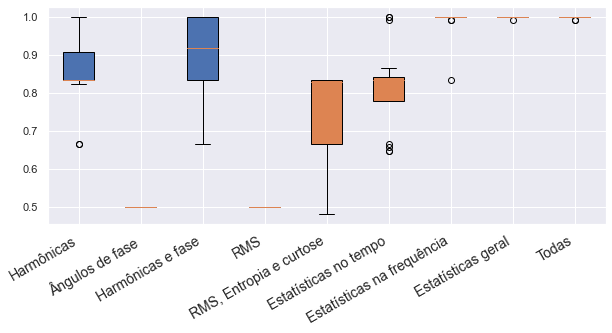

In [9]:
names = [k[1] for k in feature_models.keys()]

fig, ax = plt.subplots(figsize=(10,4))
bplot1 = ax.boxplot(acc_brutle, labels=names, patch_artist=True)

colors = ['C0']*3 + ['C1']*5 + ['C2']

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
    label.set_size(14)
plt.show()

### Por eixo

In [29]:
eixos = {
    'Axial 1':     [col for col in columns if 'ax1' in col],
    'Axial 2':     [col for col in columns if 'ax2' in col],
    'Axial':       [col for col in columns if 'ax' in col],
    'Radial 1':    [col for col in columns if 'rad1' in col],    
    'Radial 2':    [col for col in columns if 'rad2' in col],
    'Radial':      [col for col in columns if 'rad' in col],
    'Tangente 1':  [col for col in columns if 'tg1' in col],
    'Tangente 2':  [col for col in columns if 'tg2' in col],
    'Tangente':    [col for col in columns if 'tg' in col],
}

{k: v.append('rotacao_calc') for k, v in eixos.items()}

feature_models_eixos = {k: df[v] for k, v in eixos.items()}

acc_mean = []
acc_std = []

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

for data in feature_models_eixos.values():
    evaluation = cross_validate(
        estimator= clf,
        X=data.values, y=labels,
        cv=kfold,
        scoring=['balanced_accuracy'])
    
    acc_mean.append(evaluation['test_balanced_accuracy'].mean())
    acc_std.append(evaluation['test_balanced_accuracy'].std())

results = pd.DataFrame({
    'f1': [f'{m:.3f} ± {s:.3f}'.replace('.',',') for m, s in zip(acc_mean, acc_std)],
    }, index=eixos)

print(results.to_latex())
results

\begin{tabular}{ll}
\toprule
{} &             f1 \\
\midrule
Axial 1    &  0,500 ± 0,000 \\
Axial 2    &  0,720 ± 0,163 \\
Axial      &  0,902 ± 0,102 \\
Radial 1   &  0,709 ± 0,127 \\
Radial 2   &  0,761 ± 0,078 \\
Radial     &  0,948 ± 0,076 \\
Tangente 1 &  0,736 ± 0,156 \\
Tangente 2 &  0,699 ± 0,107 \\
Tangente   &  0,895 ± 0,115 \\
\bottomrule
\end{tabular}



,f1
Axial 1,"0,500 ± 0,000"
Axial 2,"0,720 ± 0,163"
Axial,"0,902 ± 0,102"
Radial 1,"0,709 ± 0,127"
Radial 2,"0,761 ± 0,078"
Radial,"0,948 ± 0,076"
Tangente 1,"0,736 ± 0,156"
Tangente 2,"0,699 ± 0,107"
Tangente,"0,895 ± 0,115"


### Por característica x eixo

In [30]:
eixos_principais = {
    'Axial':       [col for col in columns if 'ax' in col],
    'Radial':      [col for col in columns if 'rad' in col],
    'Tangente':    [col for col in columns if 'tg' in col],
}

{k: v.append('rotacao_calc') for k, v in eixos_principais.items()}

acc_mean = []
acc_std = []

i=0
for feat_type in feature_models.values():
    acc_mean.append([])
    acc_std.append([])
    for eixo in eixos_principais.values():
        df_slice = list(set(feat_type) & set(eixo))
        evaluation = cross_validate(
            estimator=clf,
            X=df[df_slice].values, y=labels,
            cv=kfold,
            scoring=['balanced_accuracy'])

        acc_mean[i].append(evaluation['test_balanced_accuracy'].mean())
        acc_std[i].append(evaluation['test_balanced_accuracy'].std())
    i+=1

In [31]:
cross_results = pd.DataFrame(acc_mean, index=index, columns=eixos_principais.keys())
# cross_results['Acurácia média'] = cross_results.mean(axis=1)
cross_results

Axial    Radial  Tangente
Tipo        Características                                         
Espectro    Harmônicas                  0.783465  0.788709  0.839154
            Ângulos de fase             0.414145  0.617623  0.606983
            Harmônicas e fase           0.776690  0.789911  0.911906
Estatístico RMS                         0.907723  0.866528  0.850808
            RMS, Entropia e curtose     0.897530  0.924609  0.866457
            Estatísticas no tempo       0.851645  0.891945  0.810980
            Estatísticas na frequência  0.905119  0.880491  0.825874
            Estatísticas geral          0.958098  0.966700  0.925233
            Todas                       0.955493  0.959111  0.967937

### Train-Test split

In [32]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.25, stratify=labels, random_state=42) 

clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, plot_roc_curve, auc

matrix = confusion_matrix(y_test, y_predicted)
matrix_df = pd.DataFrame(matrix, index=output_remap, columns=output_remap)

print(matrix_df.to_latex())
matrix_df

\begin{tabular}{lrr}
\toprule
{} &  Falha incipiente &  Normal \\
\midrule
Falha incipiente &               208 &       0 \\
Normal           &                 0 &      12 \\
\bottomrule
\end{tabular}



,Falha incipiente,Normal
Falha incipiente,208,0
Normal,0,12


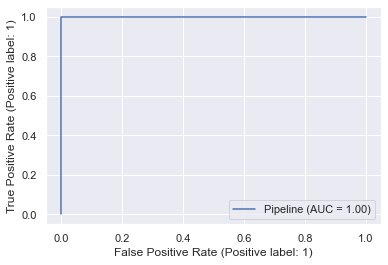

In [34]:
y_score = clf.decision_function(X_test)

plot_roc_curve(clf, X_test, y_test)

## Seleção de características

### SFS

In [35]:
# método guloso, pode demorar DIAS para computar
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator=clf, cv=kfold,
              scoring='f1', n_features_to_select=2)
sfs.fit(df, labels)
df.columns[sfs.support_]

Index(['rad2_1h', 'ax2_freqstat_rvf'], dtype='object')

### K-Best
Estatística univariada baseada em: chi2, f_classif, mutual_info_classif

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif

min_features_to_select = 1  # Minimum number of features to consider

kbest = SelectKBest(score_func=f_classif , k='all')
kbest.fit(df, labels)

sorted_features = pd.Series(kbest.scores_, index=df.columns).sort_values(ascending=False)
sorted_features[:20]

ax2_freqstat_rvf        108.414968
tg1_freqstat_rvf         76.557996
ax2_freqstat_rmsf        62.559057
ax2_2h                   44.379560
tg2_2h                   41.131695
ax2_timestat_sqew        38.026432
tg2_timestat_peak        37.445236
tg2_timestat_abs_max     35.864128
ax2_timestat_peak        35.853430
ax2_freqstat_fc          31.150256
tg2_timestat_rms         30.464183
rad1_timestat_kurt_f     30.051037
rad2_timestat_shape      29.594496
ax2_timestat_abs_max     29.063795
rad1_freqstat_rmsf       28.497005
tg2_timestat_sra         28.198131
ax2_timestat_rms         24.178005
ax2_timestat_sra         24.089270
rad2_timestat_kurt_f     23.509032
rad2_1h                  23.180856
dtype: float64

In [37]:
X = pd.DataFrame()
scores_list = []
for feature in sorted_features.index:
    X = pd.concat([X, df[feature]], axis=1)
    scores = cross_val_score(clf, X, labels, scoring='f1', cv=kfold)
    scores_list.append(scores)
    

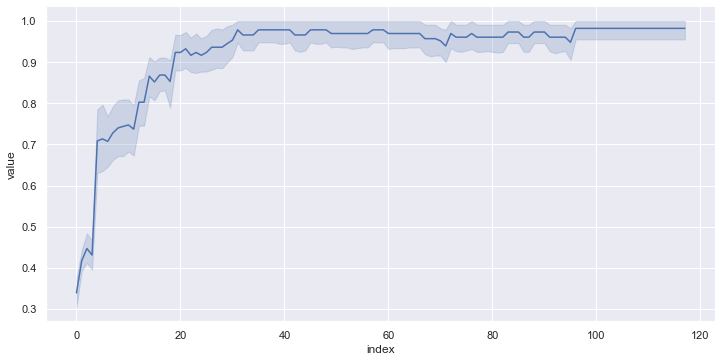

In [38]:
scores_df = pd.DataFrame(scores_list)
# scores_df['feature'] = sorted_features.index
scores_df = scores_df.reset_index().melt(id_vars='index')
scores_df
sns.relplot(data=scores_df, x='index', y='value', kind='line', aspect=2)

## Interpretabilidade do modelo

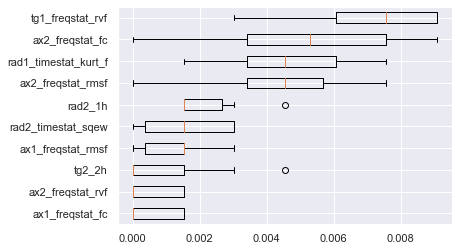

In [39]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[perm_sorted_idx][-10:].T, vert=False,
            labels=df.columns[perm_sorted_idx][-10:])
plt.show()

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 1.00


FixedFormatter should only be used together with FixedLocator


(0.0, 118.0)

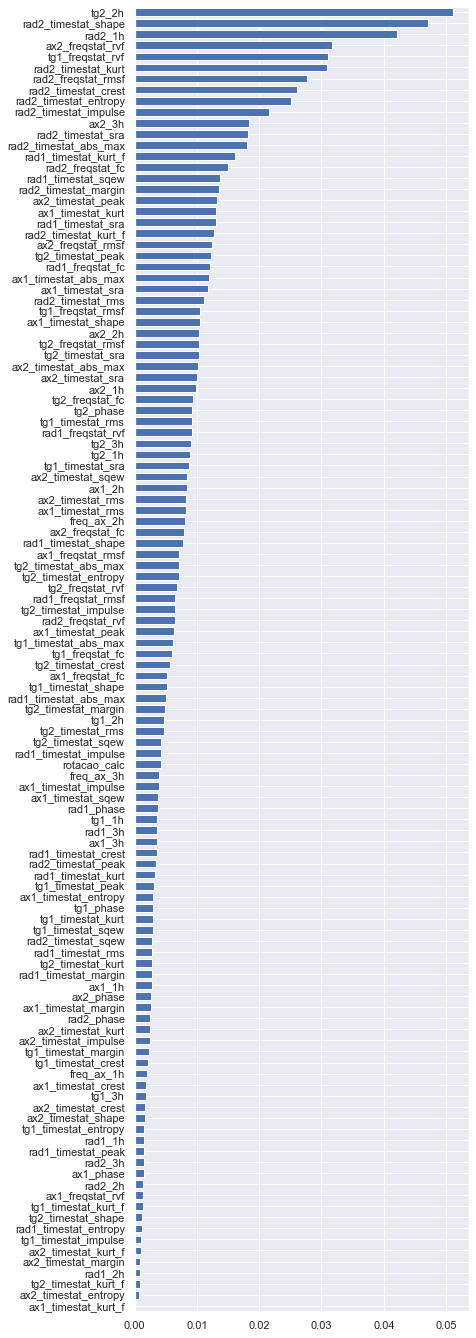

In [41]:
tree_importance_sorted_idx = np.argsort(rf_clf.feature_importances_)
tree_indices = np.arange(0, len(rf_clf.feature_importances_)) + 0.5

fig, ax = plt.subplots(1, 1, figsize=(6, 24))
ax.barh(tree_indices, rf_clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticklabels(df.columns[tree_importance_sorted_idx])
ax.set_yticks(tree_indices)
ax.set_ylim((0, len(rf_clf.feature_importances_)))

In [42]:
import shap 

# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(df)

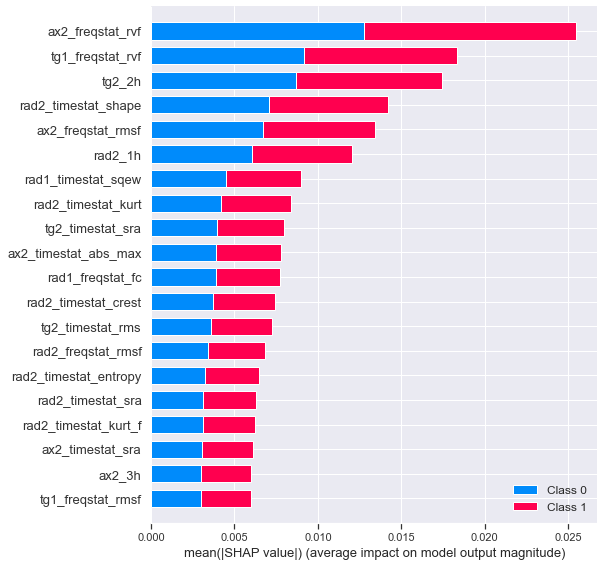

In [43]:
shap.summary_plot(shap_values, df)